In [1]:
from datetime import datetime
from os.path import join
import os
from pprint import pprint
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
import scipy
from scipy.stats import entropy
import scipy.optimize
import pickle
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

from one.api import ONE
from brainbox.io.one import SessionLoader, EphysSessionLoader
from brainbox.processing import bincount2D
from iblatlas.atlas import AllenAtlas
from brainbox.io.one import SpikeSortingLoader

from psychedelic_functions import paths
from psychedelic_functions import fetch_spikes, _get_binned_spike_counts
from psychedelic_functions import combine_regions

ba = AllenAtlas(res_um=10)
path_dict = paths()
mode = 'auto'  # sets mode for all queries (one.seach* methods)
one = ONE(mode=mode)

df_spikes = pd.read_pickle('data/spike_times.pkl')

df_timings = pd.read_csv('metadata/timings.csv').set_index('eid')
df_timings = df_timings.dropna()
df_spikes = df_spikes[np.isin(df_spikes['eid'], df_timings.index)]

/home/openlab/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/alf/files.py:10: FutureWarning: `one.alf.files` will be removed in version 3.0. Use `one.alf.path` instead.
  warnings.warn(


In [2]:
def exponential (x, tau):
        return  np.exp(-x/tau)

In [3]:
def run_pca(df_spikes, idx, session, start, stop, plot = False):
    '''Runs PCA on a chunk of recording, determined by start and stop, with start and stop being time values directly. '''
    
    print (f'Running PCA for session {idx}, for window [{start}-{stop}]')
    # dict_var = {'eid': idx}
    args = {'start': start, 'stop': stop}
    # for event in args.values():
    #         session[event] = session['eid'].apply(lambda x: df_timings.loc[x][event])
    args['dt'] = 0.1
    spike_counts = session.apply(_get_binned_spike_counts, **args, axis='columns')
    X = np.column_stack(spike_counts)  # convert it to 2D array w/ units as columns
    scaler = MinMaxScaler()
    X_norm = scaler.fit_transform(X)
    pca = PCA()
    pca.fit(X_norm)
    [tau], _ = scipy.optimize.curve_fit(exponential, np.arange(pca.n_components_), pca.explained_variance_ratio_/pca.explained_variance_ratio_[0])
    dict_measures = {}
    dict_measures[f'pc1'] = pca.explained_variance_ratio_[0]
    dict_measures[f'pcs'] = pca.explained_variance_ratio_
    dict_measures[f'tau'] = tau
    dict_measures[f'ngsc'] = entropy(pca.explained_variance_ratio_) / np.log2(pca.n_components_)
    if plot == True:
        fig, ax = plt.subplots()
        ax.plot(pca.explained_variance_ratio_)
        ax.set_xlabel('Component number')
        ax.set_ylabel(f'Variance explained')
        ax.set_title(f'Variance explained per component for session  \n {idx}')
    return dict_measures

In [4]:
def get_comparisons (idx, window_size = 300):
    spontaneous_00_start = df_timings.loc[idx, f'spontaneous_start_00']
    spontaneous_00_stop  = df_timings.loc[idx, f'spontaneous_stop_00']
    spontaneous_01_start = df_timings.loc[idx, f'spontaneous_start_01']
    spontaneous_01_stop  = df_timings.loc[idx, f'spontaneous_stop_01']

    task_replay_00_start = df_timings.loc[idx, f'rfm_stop_00']      #USING RFM_STOP INSTEAD OF REPLAY_START
    task_replay_00_stop  = df_timings.loc[idx, f'replay_stop_00']
    task_replay_01_start = df_timings.loc[idx, f'rfm_stop_01']      #USING RFM_STOP INSTEAD OF REPLAY_START
    task_replay_01_stop  = df_timings.loc[idx, f'replay_stop_01']
   
    post_LSD_00_start    = df_timings.loc[idx, 'admin_time'] + 0*(window_size)
    post_LSD_00_stop     = df_timings.loc[idx, 'admin_time'] + 1*(window_size)
    post_LSD_01_start    = df_timings.loc[idx, 'admin_time'] + 1*(window_size)
    post_LSD_01_stop     = df_timings.loc[idx, 'admin_time'] + 2*(window_size)
    post_LSD_02_start    = df_timings.loc[idx, 'admin_time'] + 2*(window_size)
    post_LSD_02_stop     = df_timings.loc[idx, 'admin_time'] + 3*(window_size)
    post_LSD_03_start    = df_timings.loc[idx, 'admin_time'] + 3*(window_size)
    post_LSD_03_stop     = df_timings.loc[idx, 'admin_time'] + 4*(window_size)
    post_LSD_04_start    = df_timings.loc[idx, 'admin_time'] + 4*(window_size)
    post_LSD_04_stop     = df_timings.loc[idx, 'admin_time'] + 5*(window_size)
    post_LSD_05_start    = df_timings.loc[idx, 'admin_time'] + 5*(window_size)
    post_LSD_05_stop     = df_timings.loc[idx, 'admin_time'] + 6*(window_size)

    comparisons = {
        'First spontaneous activity vs. First task replay'                       : [[spontaneous_00_start, spontaneous_00_stop], [task_replay_00_start, task_replay_00_stop]],
        'First spontaneous activity vs. 0-5 minutes after LSD administration'    : [[spontaneous_00_start, spontaneous_00_stop], [post_LSD_00_start, post_LSD_00_stop]],
        'First spontaneous activity vs. 5-10 minutes after LSD administration'   : [[spontaneous_00_start, spontaneous_00_stop], [post_LSD_01_start, post_LSD_01_stop]],
        'First spontaneous activity vs. 10-15 minutes after LSD administration'  : [[spontaneous_00_start, spontaneous_00_stop], [post_LSD_02_start, post_LSD_02_stop]],
        'First spontaneous activity vs. 15-20 minutes after LSD administration'  : [[spontaneous_00_start, spontaneous_00_stop], [post_LSD_03_start, post_LSD_03_stop]],
        'First spontaneous activity vs. 20-25 minutes after LSD administration'  : [[spontaneous_00_start, spontaneous_00_stop], [post_LSD_04_start, post_LSD_04_stop]],
        'First spontaneous activity vs. 25-30 minutes after LSD administration'  : [[spontaneous_00_start, spontaneous_00_stop], [post_LSD_05_start, post_LSD_05_stop]],
        'First spontaneous activity vs. Second spontaneous activity'             : [[spontaneous_00_start, spontaneous_00_stop], [spontaneous_01_start, spontaneous_01_stop]],
        'First spontaneous activity vs. Second task replay'                      : [[spontaneous_00_start, spontaneous_00_stop], [task_replay_01_start, task_replay_01_stop]],
        'First task replay vs. Second task replay'                               : [[task_replay_00_start, task_replay_00_stop], [task_replay_01_start, task_replay_01_stop]],
        'First task replay vs. Second spontaneous activity'                      : [[task_replay_00_start, task_replay_00_stop], [spontaneous_01_start, spontaneous_01_stop]]
    }
    return comparisons

In [5]:
all_measurements = []
for idx, session in df_spikes.groupby(['eid']):
    if len(session)<20:
        continue
    comparisons = get_comparisons (idx, window_size = 300)
    dict_var = {'eid': idx, 'timings': comparisons}
    for comparison in comparisons.keys():
        dict_var [f'{comparison}'] = {}
        first_window = comparisons[f'{comparison}'][0]
        second_window = comparisons[f'{comparison}'][1]
        first_window_measures  = run_pca(df_spikes, idx, session, start = first_window[0], stop = first_window[1], plot = False)
        second_window_measures  = run_pca(df_spikes, idx, session, start = second_window[0], stop = second_window[1], plot = False)
        dict_var [f'{comparison}']['first_window_measures'] = first_window_measures
        dict_var [f'{comparison}']['second_window_measures'] = second_window_measures
    all_measurements.append(dict_var)
df_pca = pd.DataFrame (all_measurements)
df_pca

/tmp/ipykernel_1588504/3915657079.py:2: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for idx, session in df_spikes.groupby(['eid']):


Running PCA for session 4b398979-c54c-498f-a3d4-b201c2285be5, for window [192.9938121947822-493.0592089759039]
Running PCA for session 4b398979-c54c-498f-a3d4-b201c2285be5, for window [806.4082376062172-1149.6444573911497]
Running PCA for session 4b398979-c54c-498f-a3d4-b201c2285be5, for window [192.9938121947822-493.0592089759039]
Running PCA for session 4b398979-c54c-498f-a3d4-b201c2285be5, for window [1184-1484]
Running PCA for session 4b398979-c54c-498f-a3d4-b201c2285be5, for window [192.9938121947822-493.0592089759039]
Running PCA for session 4b398979-c54c-498f-a3d4-b201c2285be5, for window [1484-1784]
Running PCA for session 4b398979-c54c-498f-a3d4-b201c2285be5, for window [192.9938121947822-493.0592089759039]
Running PCA for session 4b398979-c54c-498f-a3d4-b201c2285be5, for window [1784-2084]
Running PCA for session 4b398979-c54c-498f-a3d4-b201c2285be5, for window [192.9938121947822-493.0592089759039]
Running PCA for session 4b398979-c54c-498f-a3d4-b201c2285be5, for window [2084

,eid,timings,First spontaneous activity vs. First task replay,First spontaneous activity vs. 0-5 minutes after LSD administration,First spontaneous activity vs. 5-10 minutes after LSD administration,First spontaneous activity vs. 10-15 minutes after LSD administration,First spontaneous activity vs. 15-20 minutes after LSD administration,First spontaneous activity vs. 20-25 minutes after LSD administration,First spontaneous activity vs. 25-30 minutes after LSD administration,First spontaneous activity vs. Second spontaneous activity,First spontaneous activity vs. Second task replay,First task replay vs. Second task replay,First task replay vs. Second spontaneous activity
0,4b398979-c54c-498f-a3d4-b201c2285be5,{'First spontaneous activity vs. First task re...,{'first_window_measures': {'pc1': 0.0901687472...,{'first_window_measures': {'pc1': 0.0901687472...,{'first_window_measures': {'pc1': 0.0901687472...,{'first_window_measures': {'pc1': 0.0901687472...,{'first_window_measures': {'pc1': 0.0901687472...,{'first_window_measures': {'pc1': 0.0901687472...,{'first_window_measures': {'pc1': 0.0901687472...,{'first_window_measures': {'pc1': 0.0901687472...,{'first_window_measures': {'pc1': 0.0901687472...,{'first_window_measures': {'pc1': 0.0697218253...,{'first_window_measures': {'pc1': 0.0697218253...
1,53d8cb2f-3338-4bcd-81c4-6207b660eba3,{'First spontaneous activity vs. First task re...,{'first_window_measures': {'pc1': 0.1175334295...,{'first_window_measures': {'pc1': 0.1175334295...,{'first_window_measures': {'pc1': 0.1175334295...,{'first_window_measures': {'pc1': 0.1175334295...,{'first_window_measures': {'pc1': 0.1175334295...,{'first_window_measures': {'pc1': 0.1175334295...,{'first_window_measures': {'pc1': 0.1175334295...,{'first_window_measures': {'pc1': 0.1175334295...,{'first_window_measures': {'pc1': 0.1175334295...,{'first_window_measures': {'pc1': 0.1195199591...,{'first_window_measures': {'pc1': 0.1195199591...
2,6dc3fee9-6bfc-4daf-a70f-d726ac2fcfde,{'First spontaneous activity vs. First task re...,{'first_window_measures': {'pc1': 0.1213235113...,{'first_window_measures': {'pc1': 0.1213235113...,{'first_window_measures': {'pc1': 0.1213235113...,{'first_window_measures': {'pc1': 0.1213235113...,{'first_window_measures': {'pc1': 0.1213235113...,{'first_window_measures': {'pc1': 0.1213235113...,{'first_window_measures': {'pc1': 0.1213235113...,{'first_window_measures': {'pc1': 0.1213235113...,{'first_window_measures': {'pc1': 0.1213235113...,{'first_window_measures': {'pc1': 0.1259933917...,{'first_window_measures': {'pc1': 0.1259933917...
3,7149e0fc-a52d-4e93-849c-edc22d54e7a5,{'First spontaneous activity vs. First task re...,{'first_window_measures': {'pc1': 0.1550589908...,{'first_window_measures': {'pc1': 0.1550589908...,{'first_window_measures': {'pc1': 0.1550589908...,{'first_window_measures': {'pc1': 0.1550589908...,{'first_window_measures': {'pc1': 0.1550589908...,{'first_window_measures': {'pc1': 0.1550589908...,{'first_window_measures': {'pc1': 0.1550589908...,{'first_window_measures': {'pc1': 0.1550589908...,{'first_window_measures': {'pc1': 0.1550589908...,{'first_window_measures': {'pc1': 0.1193607730...,{'first_window_measures': {'pc1': 0.1193607730...
4,a7a4a70f-57ae-4586-bb2d-37422deca541,{'First spontaneous activity vs. First task re...,{'first_window_measures': {'pc1': 0.1102636541...,{'first_window_measures': {'pc1': 0.1102636541...,{'first_window_measures': {'pc1': 0.1102636541...,{'first_window_measures': {'pc1': 0.1102636541...,{'first_window_measures': {'pc1': 0.1102636541...,{'first_window_measures': {'pc1': 0.1102636541...,{'first_window_measures': {'pc1': 0.1102636541...,{'first_window_measures': {'pc1': 0.1102636541...,{'first_window_measures': {'pc1': 0.1102636541...,{'first_window_measures': {'pc1': 0.1087312706...,{'first_window_measures': {'pc1': 0.1087312706...
5,d77dd225-f7a9-4d01-996b-82c3ae73d56c,{'First spontaneous activity vs. First task re...,{'first_window_measures': {'pc1': 0.1

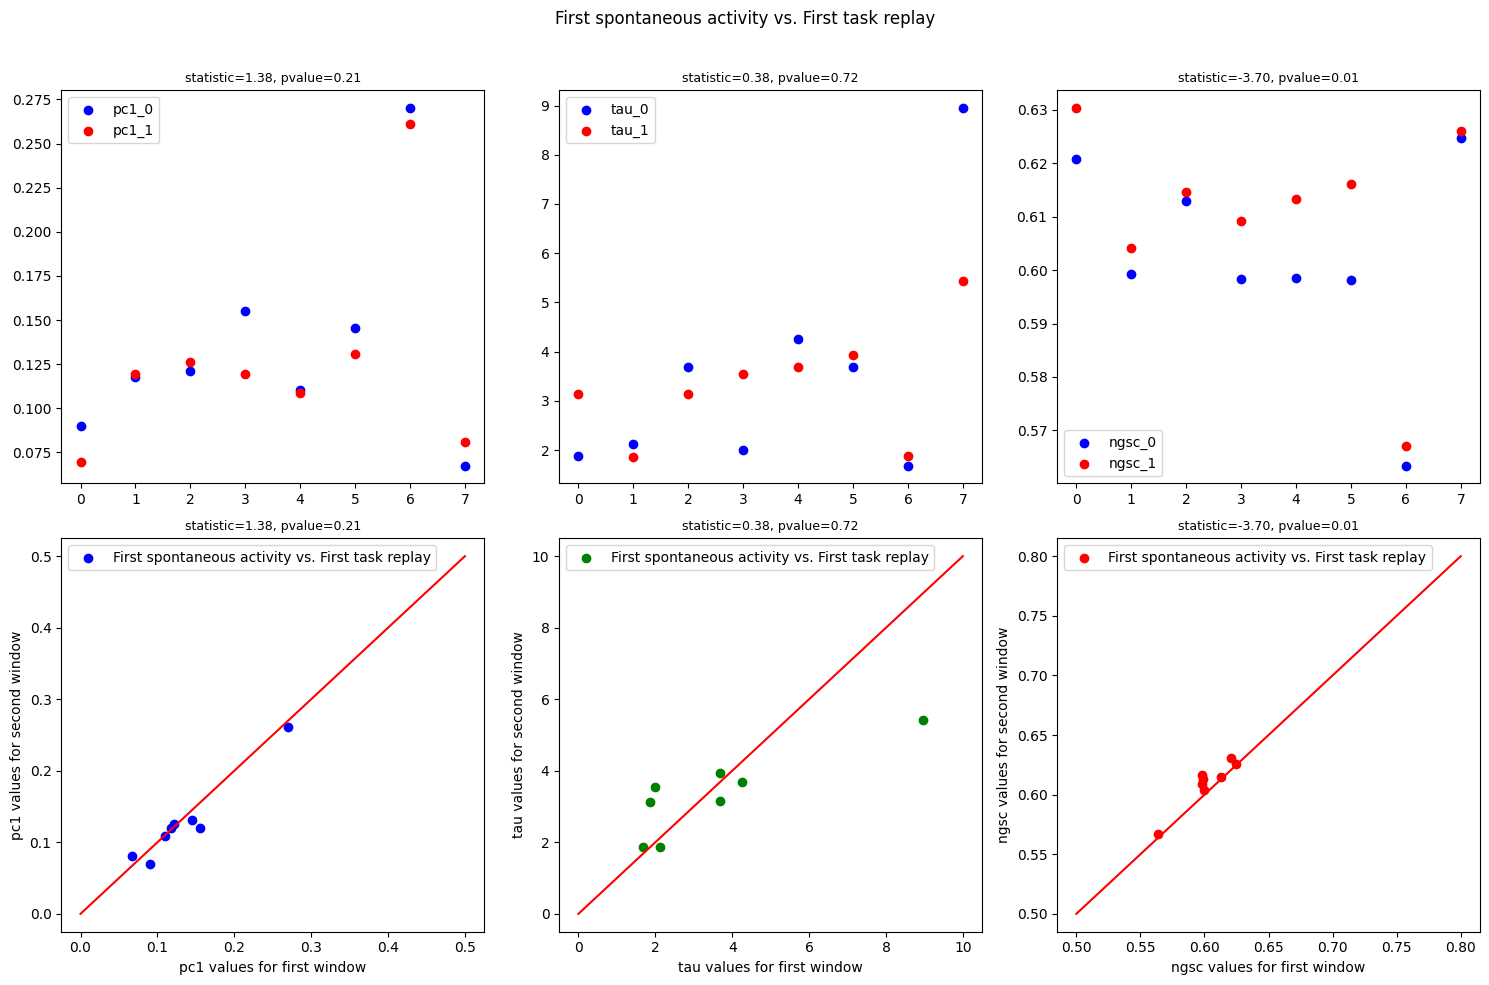

In [24]:
measures = ['pc1', 'tau', 'ngsc']  # list of measures
colors = ['b', 'g', 'r']  # Set different colors for different plots
line_dims = [[0,0.5], [0,10], [0.5, 0.8]]

for column in df_pca.columns[2::]:
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))  # change layout to 2 rows, 3 cols
    fig.suptitle(column)
    
    for i, measure in enumerate(measures):
        measure_0_values = df_pca[column].apply(lambda x: x['first_window_measures'][measure])
        measure_1_values = df_pca[column].apply(lambda x: x['second_window_measures'][measure])

        # plot on subplots in the first row
        axs[0, i].scatter(np.arange(len(measure_0_values)), measure_0_values, color='b', label=f'{measure}_0')
        axs[0, i].scatter(np.arange(len(measure_1_values)), measure_1_values, color='r', label=f'{measure}_1')

        # plot on subplots in the second row
        axs[1, i].scatter(measure_0_values, measure_1_values, color=colors[i], label=column)
        axs[1, i].plot(line_dims[i], line_dims[i], color='r')

        ttest_result = scipy.stats.ttest_rel(measure_0_values, measure_1_values)
        ttest_result_str = "statistic={:.2f}, pvalue={:.2f}".format(ttest_result.statistic, ttest_result.pvalue)
        
        axs[0, i].set_title(ttest_result_str, fontsize = 9)
        axs[1, i].set_title(ttest_result_str, fontsize = 9)
        axs[1, i].set_xlabel(f"{measure} values for first window")
        axs[1, i].set_ylabel(f"{measure} values for second window")
        
        axs[0, i].legend()
        axs[1, i].legend()

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()
    plt.close()
    break

In [ ]:
sessions = [key for key in df_pca[list(df_pca.keys())[1]].keys()]  # get all session names

# Container for results
evolutions = {'PC1': {}, 'Tau': {}, 'NGSC': {}}

for column in df_pca.columns[2::]:
    print ('column: ', column)
    for session in sessions:
        print ('session: ', session)
        for i, pair in enumerate([('pc1_0', 'pc1_1'), ('tau_0', 'tau_1'), ('ngsc_0', 'ngsc_1')]):
            pair_0_value = df_pca.at[session,column][pair[0]]
            pair_1_value = df_pca.at[session,column][pair[1]]
            difference = pair_1_value - pair_0_value
            measure = ['PC1', 'Tau', 'NGSC'][i]
            if session not in evolutions[measure]:
                evolutions[measure][session] = []
            evolutions[measure][session].append(difference)

# Now we plot
for measure in evolutions.keys():
    fig, ax = plt.subplots(figsize=(15,5)) 
    for session in evolutions[measure].keys():
        ax.plot(evolutions[measure][session], marker='.', label=session, linewidth = 1, markersize = 5)
    ax.axhline (0, color = 'black', linewidth = 2)
    ax.legend(loc='upper left')
    ax.set_xlabel('Iteration number')
    ax.set_ylabel(f'{measure} difference values')
    ax.set_title(f'Evolution of {measure} values')
    plt.show()

column:  First spontaneous activity vs. First task replay
column:  First spontaneous activity vs. 0-5 minutes after LSD administration
column:  First spontaneous activity vs. 5-10 minutes after LSD administration
column:  First spontaneous activity vs. 10-15 minutes after LSD administration
column:  First spontaneous activity vs. 15-20 minutes after LSD administration
column:  First spontaneous activity vs. 20-25 minutes after LSD administration
column:  First spontaneous activity vs. 25-30 minutes after LSD administration
column:  First spontaneous activity vs. Second spontaneous activity
column:  First spontaneous activity vs. Second task replay
column:  First task replay vs. Second task replay
column:  First task replay vs. Second spontaneous activity


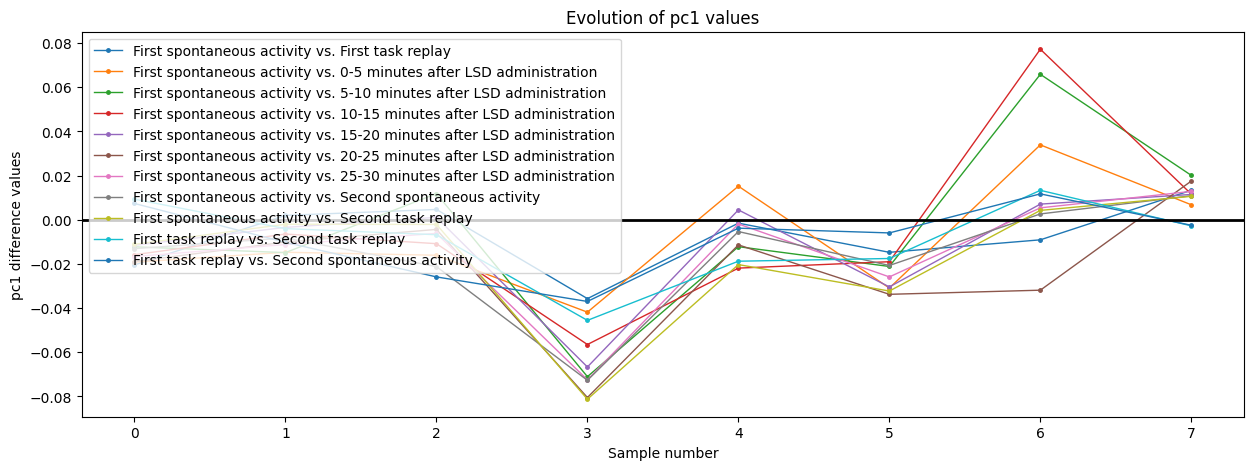

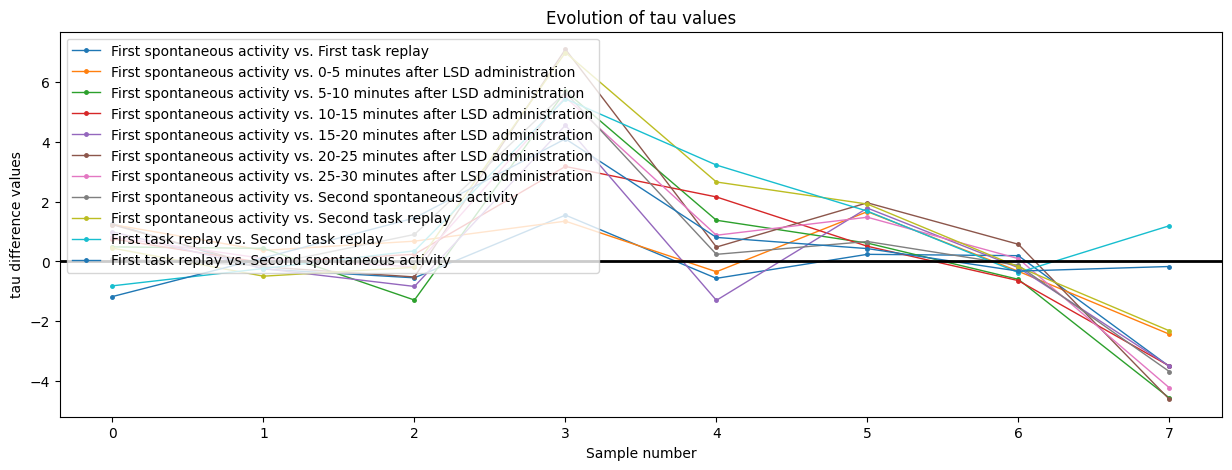

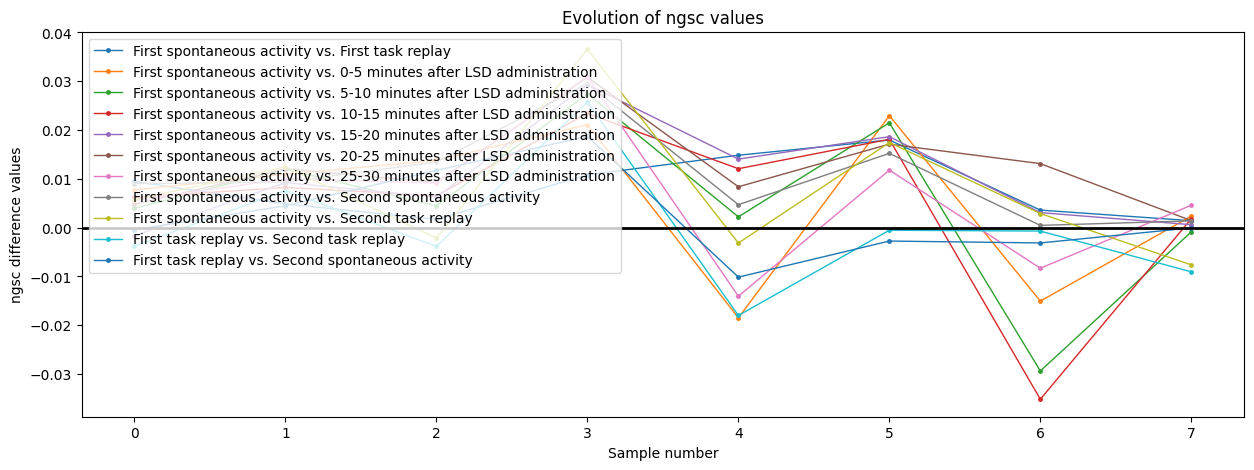

In [26]:
measures = ['pc1', 'tau', 'ngsc']  # list of measures

# Container for results
evolutions = {'pc1': {}, 'tau': {}, 'ngsc': {}}

for column in df_pca.columns[2::]:  # Loop through sessions
    print('column: ', column)
    for i, measure in enumerate(measures):
        measure_0_values = df_pca[column].apply(lambda x: x['first_window_measures'][measure])
        measure_1_values = df_pca[column].apply(lambda x: x['second_window_measures'][measure])
        differences = measure_1_values - measure_0_values  # Calculate differences
        if column not in evolutions[measure]:
            evolutions[measure][column] = []
        evolutions[measure][column].extend(list(differences))

# Now we plot
for measure in evolutions.keys():
    fig, ax = plt.subplots(figsize=(15,5))
    for column in evolutions[measure].keys():
        ax.plot(evolutions[measure][column], marker='.', label=column, linewidth = 1, markersize = 5)
    ax.axhline(0, color='black', linewidth = 2)
    ax.legend(loc='upper left')
    ax.set_xlabel('Sample number')
    ax.set_ylabel(f'{measure} difference values')
    ax.set_title(f'Evolution of {measure} values')
    plt.show()